In [1]:
from sklearn.preprocessing import StandardScaler
from math import sqrt
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean
from scipy.stats import energy_distance
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from typing import Optional
import scipy

MONTANA_ENERGY=[31.82001509061525, -106.21586560346859]
FORTBLISS_ENERGY=[31.82999, -106.37286]
CAMS49=[31.6675435,-106.2879750]

file_path=r"C:\Users\Zelda64\Documents\Programming\dust_solar_power"
file_montana_solar=os.path.join(file_path,"Montana_Solar_Facility_net_generation.csv")
file_fortbliss_solar=os.path.join(file_path,"Fort_Bliss_(DEA_EPIC)_net_generation.csv")
montana_energy_mw=pd.read_csv(file_montana_solar, header=[4], index_col=0,engine="python")
fortbliss_energy_mw=pd.read_csv(file_fortbliss_solar, header=[4], index_col=0, engine="python")

with open(os.path.join(file_path,'keys.json')) as f:
    d = json.load(f)
    api_key=d['api_key']
    email=d['email']

In [2]:
#Finding the appropriate solar modules for both locations based on satellite imagery and data found online
cec_modules=pd.read_csv(os.path.join(file_path,"CEC_Modules.csv"), header=[0],skiprows=[1,2])
cec_modules
cec_modules_cdte=cec_modules[cec_modules['Technology']=='CdTe']
cec_modules_cdte=cec_modules_cdte[cec_modules_cdte["Manufacturer"]=='First Solar Inc.']

cec_modules_cSi=cec_modules[cec_modules['Technology']=='Mono-c-Si']
cec_modules_cSi[cec_modules_cSi["Length"].notna()]
cec_modules_cSi=cec_modules_cSi[cec_modules_cSi["Length"]<=1.7]
cec_modules_cSi=cec_modules_cSi[cec_modules_cSi["Length"]>1.6]
cec_modules_cSi=cec_modules_cSi[cec_modules_cSi["Width"]<=1.0]
cec_modules_cSi=cec_modules_cSi[cec_modules_cSi["Width"]>0.99]
cec_modules_cSi=cec_modules_cSi[cec_modules_cSi["Manufacturer"]=='Jinko Solar Co. Ltd']
#cec_modules_cSi
#cec_modules_cdte

In [3]:
cec_inverters=pd.read_csv(os.path.join(file_path,"CEC_Inverters.csv"), header=[0],skiprows=[1,2])
cec_inverters=cec_inverters[cec_inverters['Pdco']<27500]
cec_inverters=cec_inverters[cec_inverters['Pdco']>25000]
cec_inverters

,Name,Vac,Pso,Paco,Pdco,Vdco,C0,C1,C2,C3,Pnt,Vdcmax,Idcmax,Mppt_low,Mppt_high,CEC_Date,CEC_hybrid
188,CSI Solar Co - Ltd : CSI-25K-T480GL01-UB [480V],480,28.9305,24958.0,25377.7,470.0,-2.441600e-07,-4.976690e-07,0.000519,0.000650,1.0,800.0,53.9951,347.0,800.0,12/1/2021,N
189,CSI Solar Co - Ltd : CSI-25KTL-GS-FLB [480V],480,68.8259,25000.0,25568.0,650.0,-3.729170e-07,1.672410e-05,-0.000736,0.001291,14.0,770.0,39.3353,580.0,770.0,12/1/2021,N
210,Canadian Solar Inc : CSI-25KTL-GS-FL [480V],480,65.3352,25000.0,25581.9,650.0,-3.961770e-07,1.350590e-05,0.000622,0.002894,14.0,780.0,39.3568,580.0,780.0,11/15/2019,N
231,Chint Power Systems America: CPS SCA25KTL-DO-R...,480,37.6542,25000.0,25548.1,735.0,-4.006700e-07,-2.672780e-05,-0.001418,-0.001992,3.0,850.0,34.7593,560.0,850.0,6/13/2022,N
232,Chint Power Systems America: CPS SCA25KTL-DO/U...,208,79.0357,25000.0,25971.3,575.0,-6.615420e-07,1.591300e-05,0.001805,0.000251,2.9,850.0,45.1676,480.0,850.0,2/1/2023,N
294,Delta Electronics: M24U_120 [480V],480,69.9273,26403.0,26885.2,710.0,-2.520400e-07,-2.744700e-05,-0.001203,-0.000930,2.6,830.0,37.8664,415.0,830.0,3/2/2020,N
295,Delta Electronics: M24U_121 [480V],480,69.9273,26403.0,26885.2,710.0,-2.520400e-07,-2.744700e-05,-0.001203,-0.000930,2.6,830.0,37.8664,415.0,830.0,3/2/2020,N
296,Delta Electronics: M24U_122 [480V],480,69.9273,26403.0,26885.2,710.0,-2.520400e-07,-2.744700e-05,-0.001203,-0.000930,2.6,830.0,37.8664,415.0,830.0,3/2/2020,N
646,Ginlong Technologies Co - Ltd : Solis-25K-US [...,480,65.3352,25000.0,25581.9,650.0,-3.961770e-07,1.350590e-05,0.000622,0.002894,14.0,780.0,39.3568,580.0,780.0,11/15/2019,N
647,Ginlong Technologies Co - Ltd : Solis-25K-US-L...,480,28.9305,24958.0,25377.7,470.0,-2.441600e-07,-4.976690e-07,0.000519,0.000650,1.0,800.0,53.9951,347.0,800.0,NaN,N


In [4]:
# Retrieve the CEC inverter database
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
# Search for an inverter by part of its name (e.g., 'SMA' for SMA inverters)
filtered_inverters = cec_inverters.filter(like='Canadian_Solar_Inc___CSI_25KTL_GS_FL__480V_', axis=1)
print(filtered_inverters.columns)

Index(['Canadian_Solar_Inc___CSI_25KTL_GS_FL__480V_'], dtype='object')


In [5]:
# Retrieve the CEC inverter database
cec_modules = pvlib.pvsystem.retrieve_sam('cecmod')
# Search for an inverter by part of its name (e.g., 'SMA' for SMA inverters)
filtered_modules = cec_modules.filter(like='AS_6M_350W', axis=1)
print(filtered_modules.columns)

Index(['Amerisolar_Worldwide_Energy_and_Manufacturing_USA_Co___Ltd_AS_6M_350W'], dtype='object')


In [6]:
print(montana_energy_mw['Dec 2021':'Jan 2019'].isna().sum())
montana_energy_mw=montana_energy_mw['Dec 2021':'Jan 2019'].dropna()
montana_energy_mw = montana_energy_mw.rename(columns={'All primemovers - All fuels (ALL) megawatthours': 'Actual Production'})
fortbliss_energy_mw=fortbliss_energy_mw['Dec 2021':'Jan 2019'].dropna()
fortbliss_energy_mw = fortbliss_energy_mw.rename(columns={'All primemovers - All fuels (ALL) megawatthours': 'Actual Production'})

All primemovers - All fuels (ALL) megawatthours    30
dtype: int64


In [7]:
montana_energy_mw.index= pd.to_datetime(montana_energy_mw.index, format='%b %Y')
montana_energy_mw=montana_energy_mw.sort_values(by=['Month'])

fortbliss_energy_mw.index=pd.to_datetime(fortbliss_energy_mw.index, format='%b %Y')
fortbliss_energy_mw=fortbliss_energy_mw.sort_values(by=['Month'])

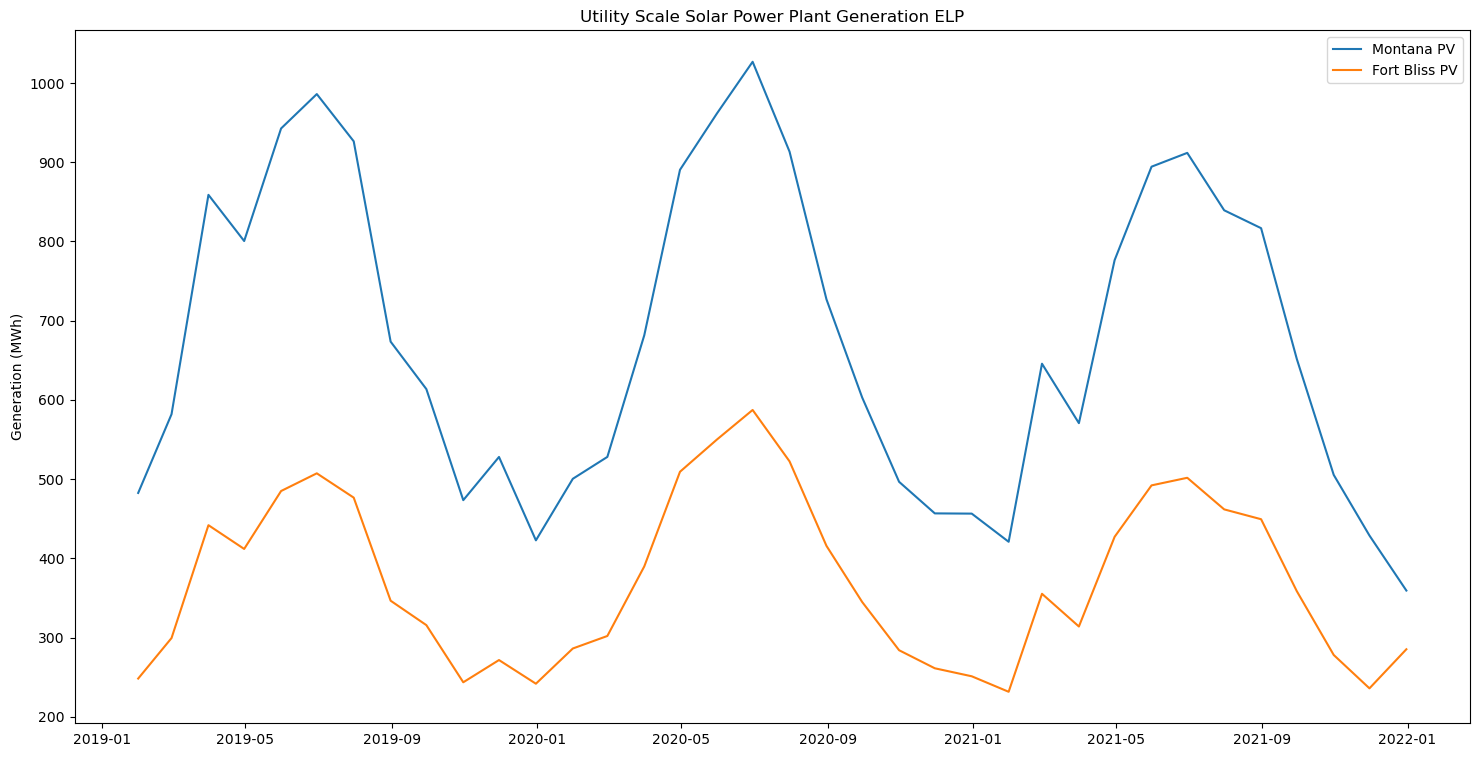

In [8]:
date_range=pd.date_range(start='2019-01-01', end='2022-01-01', freq='M')
#date_range.shape is 36
plt.subplots(figsize=(18, 9))
plt.title("Utility Scale Solar Power Plant Generation ELP")
plt.plot(date_range, montana_energy_mw.values.flatten(), label='Montana PV')
plt.plot(date_range, fortbliss_energy_mw.values.flatten(), label='Fort Bliss PV')
plt.ylabel("Generation (MWh)")
plt.legend()
plt.show()

In [9]:
#Example from https://pvlib-python.readthedocs.io/en/stable/gallery/system-models/plot_oedi_9068.html#sphx-glr-gallery-system-models-plot-oedi-9068-py

def pvsystem_parameters(latitude, longitude, modules_per_string, strings_per_inverter, num_inverters, module_type, module_technology, inverter_type, 
                        module_width, module_length, module_weight, module_number_vertical, pitch, azimuth, fixed_tilt, fixed_tilt_angle: Optional[float] = None):
    

    cec_module_db = pvlib.pvsystem.retrieve_sam('cecmod')
    module_parameters = cec_module_db[module_type]
    module_parameters['Technology'] = module_technology
    # default Faiman model parameters:
    temperature_model_parameters = dict(u0=25.0, u1=6.84)
    module_unit_mass = module_weight / (module_length*module_width) # kg/m^2, taken from datasheet values
    
    cec_inverter_db = pvlib.pvsystem.retrieve_sam('cecinverter')
    inverter_parameters = cec_inverter_db[inverter_type]
    
    # Using PVWatts v5 losses model, set shading, availability and soiling to zero
    # Will define soiling losses separately
    # Leaving the other pvwatts loss types (mismatch, wiring, etc) unspecified
    # causes them to take their default values.
    losses_parameters = dict(shading=0, availability=0, soiling=0)
    
    gcr = (module_number_vertical * module_width + (module_number_vertical-1) * 0.01) / pitch
    axis_azimuth = azimuth  # degrees
    axis_height = 1.5  # meters

    location = pvlib.location.Location(latitude, longitude)
    if fixed_tilt==False:
        # The tracker rotation measurements reveal that the tracker rotation limits
        # are +/- 60 degrees, and backtracking is not enabled:
        max_angle = 60  # degrees
        backtrack = False
        mount = pvlib.pvsystem.SingleAxisTrackerMount(
            gcr=gcr,
            backtrack=backtrack,
            max_angle=max_angle,
            axis_azimuth=axis_azimuth
        )
    else:
        mount = pvlib.pvsystem.FixedMount(
            surface_tilt=fixed_tilt_angle,
            surface_azimuth=azimuth,
            racking_model='open-rack',
            module_height=axis_height
        )
    array = pvlib.pvsystem.Array(
        mount,
        module_parameters=module_parameters,
        modules_per_string=modules_per_string,
        temperature_model_parameters=temperature_model_parameters,
        strings=strings_per_inverter
    )
    system = pvlib.pvsystem.PVSystem(
        array,
        inverter_parameters=inverter_parameters,
        losses_parameters=losses_parameters
    )
    
    model = pvlib.modelchain.ModelChain(
        system,
        location,
        spectral_model='first_solar',
        aoi_model='physical',
        losses_model='pvwatts'
    )

    pvlib_models_df_2019=pd.DataFrame()
    pvlib_models_df_2020=pd.DataFrame()
    pvlib_models_df_2021=pd.DataFrame()
    keys = ['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed',
        'albedo', 'precipitable_water']
    for year in [2019,2020,2021]:
        
        psm3, psm3_metadata = pvlib.iotools.get_psm3(latitude, longitude, api_key,
                                                     email, interval=5, names=year,
                                                     map_variables=True, leap_day=True,
                                                     attributes=keys)
        solar_position = location.get_solarposition(psm3.index, latitude, longitude)
        tracker_angles = mount.get_orientation(
            solar_position['apparent_zenith'],
            solar_position['azimuth']
        )
        dni_extra = pvlib.irradiance.get_extra_radiation(psm3.index)
        
        # note: this system is monofacial
        averaged_irradiance = pvlib.bifacial.infinite_sheds.get_irradiance_poa(
            tracker_angles['surface_tilt'], tracker_angles['surface_azimuth'],
            solar_position['apparent_zenith'], solar_position['azimuth'],
            gcr, axis_height, pitch,
            psm3['ghi'], psm3['dhi'], psm3['dni'], psm3['albedo'],
            model='haydavies', dni_extra=dni_extra,
        )
        cell_temperature_steady_state = pvlib.temperature.faiman(
        poa_global=averaged_irradiance['poa_global'],
        temp_air=psm3['temp_air'],
        wind_speed=psm3['wind_speed'],
        **temperature_model_parameters,
        )
        
        cell_temperature = pvlib.temperature.prilliman(
            cell_temperature_steady_state,
            psm3['wind_speed'],
            unit_mass=module_unit_mass
        )
        weather_inputs = pd.DataFrame({
        'poa_global': averaged_irradiance['poa_global'],
        'poa_direct': averaged_irradiance['poa_direct'],
        'poa_diffuse': averaged_irradiance['poa_diffuse'],
        'cell_temperature': cell_temperature,
        'precipitable_water': psm3['precipitable_water'],  # for the spectral model
        })
        model.run_model_from_poa(weather_inputs)
        #If the modules, mounting, stringing, and inverters are all identical for each inverter, 
        #then you may simply simulate one inverter and multiply the ModelChainResult.ac by the number of inverters to get the total system output.
        ac_output = model.results.ac
        #daily_soiling_losses should be taken from rate of soiling estimation made based on PM and dustscore
        #a Series of percentagesper day
        daily_soiling_losses=1
        ac_output_with_soiling = ac_output * daily_soiling_losses
        if year==2019:
            pvlib_models_df_2019['model'] = ac_output_with_soiling / 1000 / 1000 * num_inverters# convert W to MW
            
        elif year==2020:
            pvlib_models_df_2020['model'] = ac_output_with_soiling / 1000 / 1000 * num_inverters# convert W to MW
        else:
            pvlib_models_df_2021['model'] = ac_output_with_soiling / 1000 / 1000 * num_inverters# convert W to MW
            
    return pvlib_models_df_2019, pvlib_models_df_2020, pvlib_models_df_2021, model

<h3>Montana Energy PVlib Model<h3>

In [10]:
mont_module_pitch=7
mont_module_width=0.6
mont_module_length=1.2
mont_module_weight=12
mont_module_number_vertical=4
mont_modules_per_string=60
mont_strings_per_inverter=2
mont_num_inverters=276
mont_module_type='First_Solar__Inc__FS_4122A_3'
mont_inverter_type='SunPower__SPR_15000m_3_H__480V_'
mont_module_dc_w=122.5
mont_module_technology="CdTe"
mont_azimuth=180

In [11]:
pvlib_models_df_2019, pvlib_models_df_2020, pvlib_models_df_2021, model= pvsystem_parameters(MONTANA_ENERGY[0], MONTANA_ENERGY[1], mont_modules_per_string, 
                                                                                      mont_strings_per_inverter, mont_num_inverters, mont_module_type, 
                                                                                      mont_module_technology, mont_inverter_type, mont_module_width, mont_module_length, 
                                                                                      mont_module_weight, mont_module_number_vertical, mont_module_pitch, mont_azimuth, False)

C:\Users\Zelda64\miniconda3\envs\cmip6_python\Lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in divide
  smoothed = numerator / denominator
C:\Users\Zelda64\miniconda3\envs\cmip6_python\Lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in divide
  smoothed = numerator / denominator
C:\Users\Zelda64\miniconda3\envs\cmip6_python\Lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in divide
  smoothed = numerator / denominator


Montana Energy 2019 Production (MW):  11241.90466152525
Montana Energy 2020 Production (MW):  11564.448615585647
Montana Energy 2021 Production (MW):  11406.639224163488


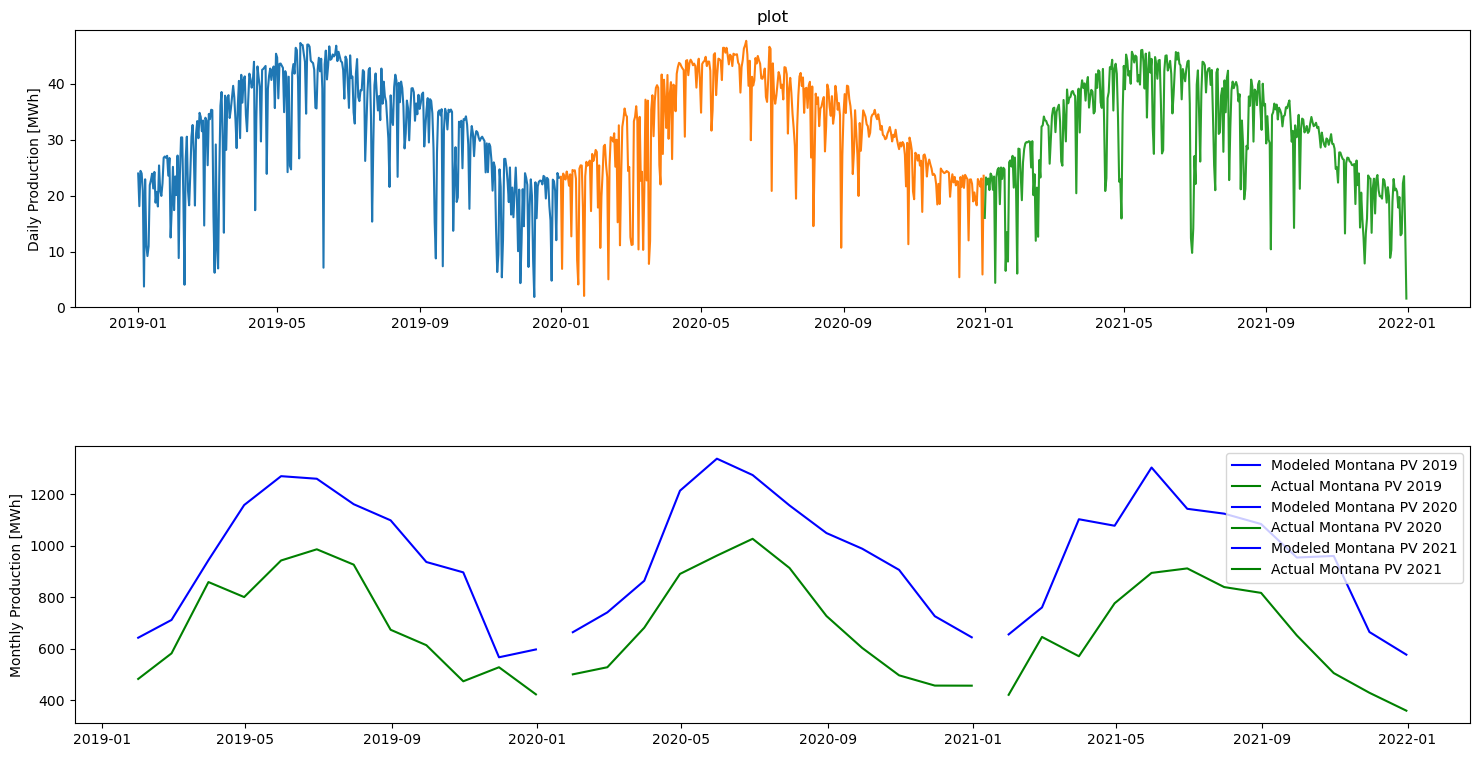

In [12]:
fig, ax = plt.subplots(2,1,figsize=(18, 9))
ax[0].set_title('plot')
plt.subplots_adjust(hspace=0.5)
count_years=1
mont_annual_production_list_2019=np.array([])
mont_annual_production_list_2020=np.array([])
mont_annual_production_list_2021=np.array([])
for year in [2019,2020,2021]:
    date_range_day=pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
    date_range_month=pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='M')


    if year==2019:
        daily_energy = pvlib_models_df_2019.clip(lower=0).resample('h').mean().resample('d').sum()
        monthly_energy = daily_energy.resample('m').sum()
        mont_annual_production_list_2019=np.append(mont_annual_production_list_2019,monthly_energy)
    elif year==2020:
        daily_energy = pvlib_models_df_2020.clip(lower=0).resample('h').mean().resample('d').sum()
        monthly_energy = daily_energy.resample('M').sum()
        mont_annual_production_list_2020=np.append(mont_annual_production_list_2020,monthly_energy)
    else:
        daily_energy = pvlib_models_df_2021.clip(lower=0).resample('h').mean().resample('d').sum()
        monthly_energy = daily_energy.resample('M').sum()
        mont_annual_production_list_2021=np.append(mont_annual_production_list_2021,monthly_energy)
    #print(daily_energy,date_range)
    #daily_energy.plot(ax=ax)
    ax[0].plot(date_range_day,daily_energy)
    ax[0].set_ylim(bottom=0)
    ax[0].set_ylabel('Daily Production [MWh]')
    
    ax[1].plot(date_range_month,monthly_energy, color='b',label=f'Modeled Montana PV {year}')
    ax[1].plot(date_range_month, montana_energy_mw[montana_energy_mw.index.year==year].values.flatten(),color='g', label=f'Actual Montana PV {year}')
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('Monthly Production [MWh]')
    count_years+=1
print("Montana Energy 2019 Production (MW): ", mont_annual_production_list_2019.sum())
print("Montana Energy 2020 Production (MW): ", mont_annual_production_list_2020.sum())
print("Montana Energy 2021 Production (MW): ", mont_annual_production_list_2021.sum())

In [13]:
mont_psm3, mont_psm3_metadata = pvlib.iotools.get_psm3(MONTANA_ENERGY[0], MONTANA_ENERGY[1], api_key, email, interval=5, names=2019, 
                                             map_variables=True, leap_day=True, attributes=('air_temperature', 'dew_point', 'dhi', 'dni', 'ghi', 
                                                                                            'surface_albedo', 'surface_pressure', 'wind_direction', 
                                                                                            'wind_speed'))

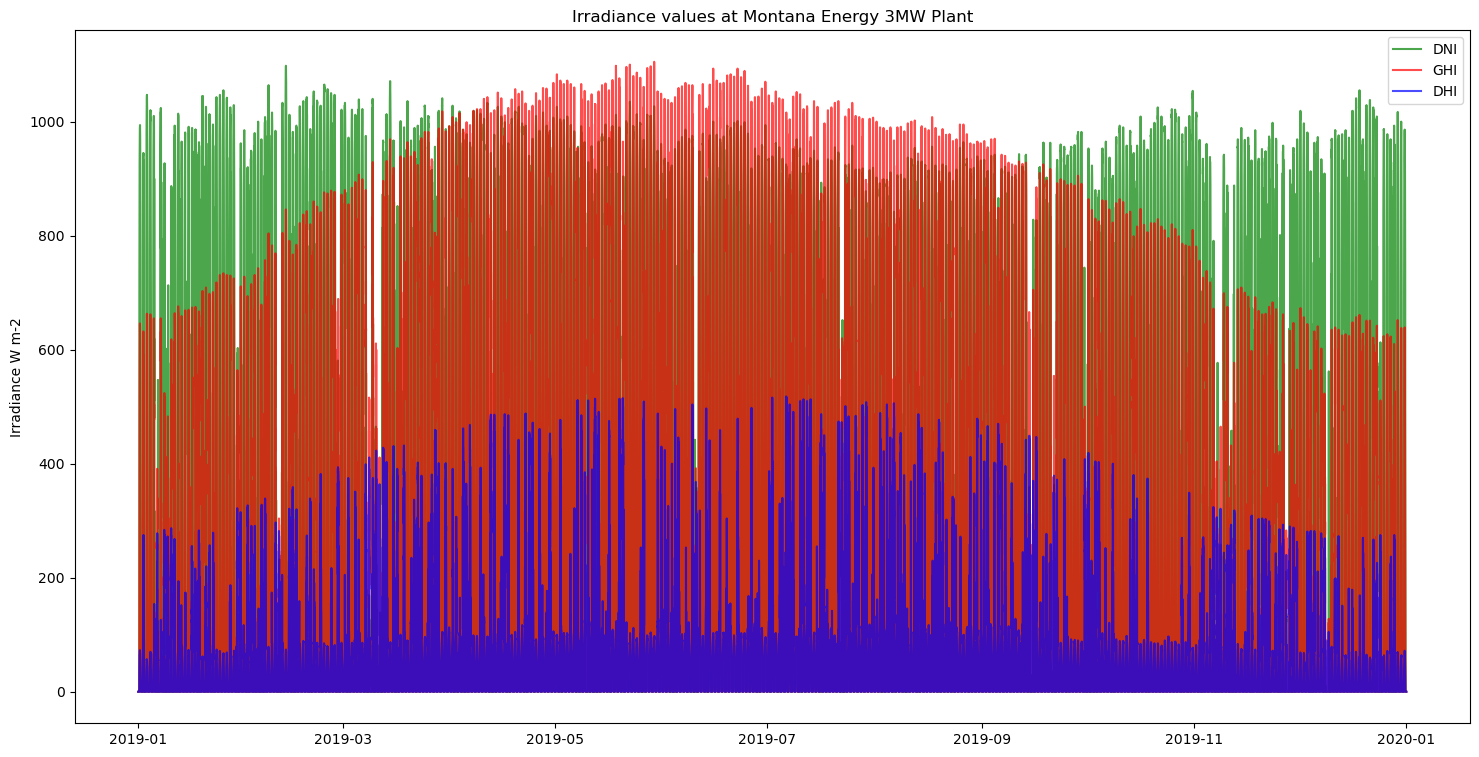

In [14]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_title("Irradiance values at Montana Energy 3MW Plant")
ax.set_ylabel("Irradiance W m-2")
ax.plot(mont_psm3["dni"], alpha=0.7, color='green',label='DNI')
ax.plot(mont_psm3["ghi"], alpha=0.7, color='red',label='GHI')
ax.plot(mont_psm3["dhi"], alpha=0.7, color='blue',label='DHI')
ax.legend(loc='upper right')

<h3>Fort Bliss PVlib Model<h3>

In [15]:
fort_module_pitch=5.8
fort_module_width=0.99
fort_module_length=1.8
fort_module_weight=12
fort_module_number_vertical=2
fort_modules_per_string=18
fort_strings_per_inverter=4
fort_num_inverters=102
#fort_module_type='Jinko_Solar_Co___Ltd_JKM300M_72'
fort_module_type='Amerisolar_Worldwide_Energy_and_Manufacturing_USA_Co___Ltd_AS_6M_350W'
#fort_inverter_type='SunPower__SPR_20000m_3_H__480V_'
fort_inverter_type='Canadian_Solar_Inc___CSI_25KTL_GS_FL__480V_'
fort_module_technology="Mono-c-Si"
fort_fixed_tilt=15
#most optimal tilt angle was found to be 27
fort_azimuth=179


In [16]:
fort_pvlib_models_df_2019, fort_pvlib_models_df_2020, fort_pvlib_models_df_2021, fort_model= pvsystem_parameters(FORTBLISS_ENERGY[0], FORTBLISS_ENERGY[1], fort_modules_per_string, 
                                                                                      fort_strings_per_inverter, fort_num_inverters, fort_module_type, 
                                                                                      fort_module_technology, fort_inverter_type, fort_module_width, fort_module_length, 
                                                                                      fort_module_weight, fort_module_number_vertical, fort_module_pitch, fort_azimuth, True, fort_fixed_tilt)

Annual Power Production 2019:  4949.5577566741595
Annual Power Production 2020:  5136.450623509438
Annual Power Production 2021:  5048.019649617838


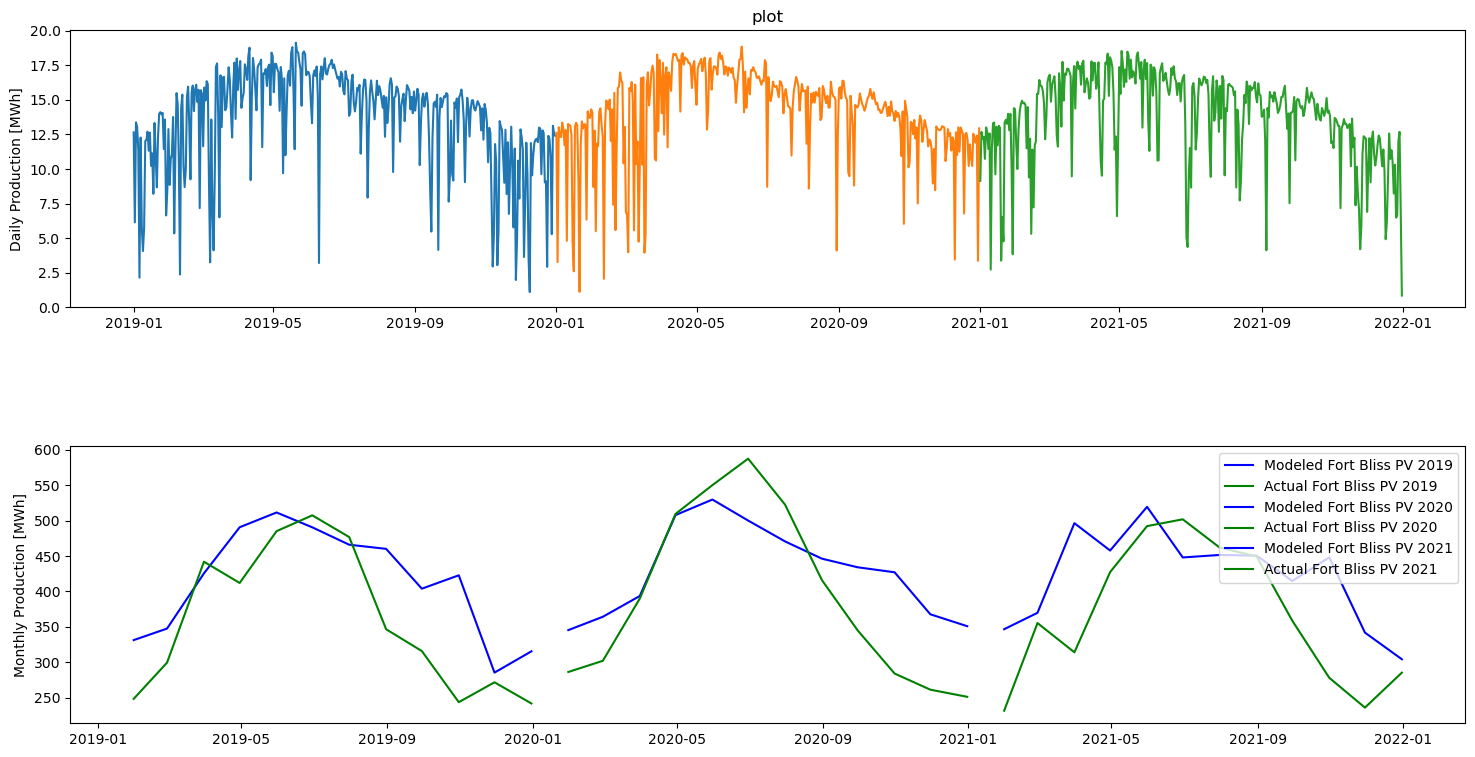

In [17]:
fig, ax = plt.subplots(2,1,figsize=(18, 9))
ax[0].set_title('plot')
plt.subplots_adjust(hspace=0.5)
count_years=1
fort_annual_production_list_2019=np.array([])
fort_annual_production_list_2020=np.array([])
fort_annual_production_list_2021=np.array([])

for year in [2019,2020,2021]:
    date_range_day=pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
    date_range_month=pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='M')


    if year==2019:
        daily_energy = fort_pvlib_models_df_2019.clip(lower=0).resample('h').mean().resample('d').sum()
        monthly_energy = daily_energy.resample('m').sum()
        #annual_production = monthly_energy.resample('y').sum()
        fort_annual_production_list_2019=np.append(fort_annual_production_list_2019,monthly_energy)
    elif year==2020:
        daily_energy = fort_pvlib_models_df_2020.clip(lower=0).resample('h').mean().resample('d').sum()
        monthly_energy = daily_energy.resample('M').sum()
        #annual_production = monthly_energy.resample('y').sum()
        fort_annual_production_list_2020=np.append(fort_annual_production_list_2020,monthly_energy)
    else:
        daily_energy = fort_pvlib_models_df_2021.clip(lower=0).resample('h').mean().resample('d').sum()
        monthly_energy = daily_energy.resample('M').sum()
        #annual_production = monthly_energy.resample('y').sum()
        fort_annual_production_list_2021=np.append(fort_annual_production_list_2021,monthly_energy)
        
    #print(daily_energy,date_range)
    #daily_energy.plot(ax=ax)
    ax[0].plot(date_range_day,daily_energy)
    ax[0].set_ylim(bottom=0)
    ax[0].set_ylabel('Daily Production [MWh]')
    
    ax[1].plot(date_range_month,monthly_energy, color='b',label=f'Modeled Fort Bliss PV {year}')
    ax[1].plot(date_range_month, fortbliss_energy_mw[fortbliss_energy_mw.index.year==year].values.flatten(),color='g', label=f'Actual Fort Bliss PV {year}')
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('Monthly Production [MWh]')
    count_years+=1
print("Annual Power Production 2019: ",fort_annual_production_list_2019.sum())
print("Annual Power Production 2020: ",fort_annual_production_list_2020.sum())
print("Annual Power Production 2021: ",fort_annual_production_list_2021.sum())

In [18]:
fort_psm3, fort_psm3_metadata = pvlib.iotools.get_psm3(FORTBLISS_ENERGY[0], FORTBLISS_ENERGY[1], api_key, email, interval=5, names=2019, 
                                             map_variables=True, leap_day=True, attributes=('air_temperature', 'dew_point', 'dhi', 'dni', 'ghi', 
                                                                                            'surface_albedo', 'surface_pressure', 'wind_direction', 
                                                                                            'wind_speed'))

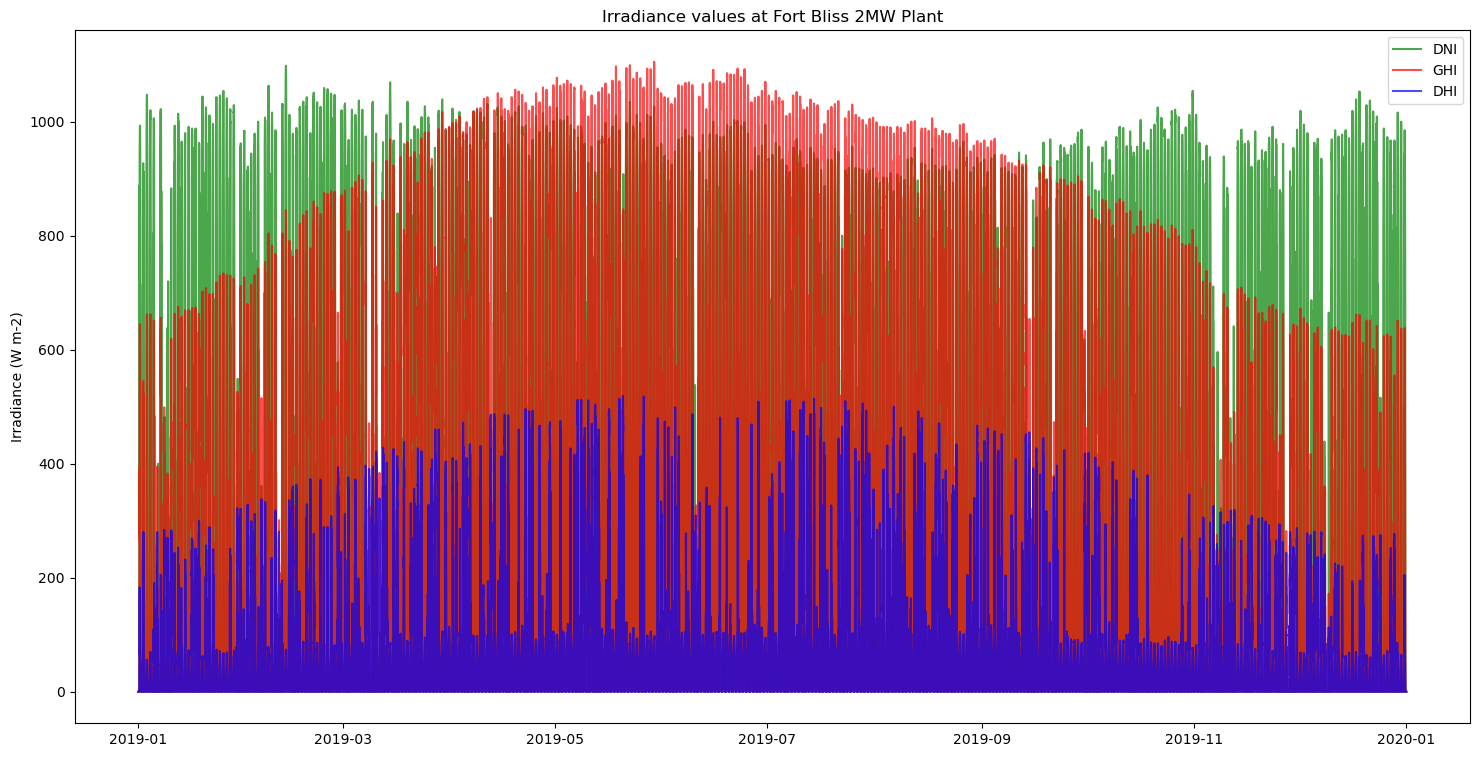

In [19]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_title("Irradiance values at Fort Bliss 2MW Plant")
ax.set_ylabel("Irradiance (W m-2)")
ax.plot(fort_psm3["dni"], alpha=0.7, color='g',label='DNI')
ax.plot(fort_psm3["ghi"], alpha=0.7, color='r',label='GHI')
ax.plot(fort_psm3["dhi"], alpha=0.7, color='b',label='DHI')
ax.legend(loc='upper right')

<h3>Statistics</h3>

In [20]:
fort_mw=np.array([])
fort_mw=np.append(fort_mw,[fort_annual_production_list_2019,fort_annual_production_list_2020,fort_annual_production_list_2021])

In [21]:
fortbliss_energy_mw['pvlib model']=fort_mw

In [22]:
fortbliss_energy_mw

,Actual Production,pvlib model
Month,,
2019-01-01,248.305,331.246596
2019-02-01,299.423,347.501151
2019-03-01,441.888,425.429711
2019-04-01,411.890,490.516605
2019-05-01,484.993,511.365117
2019-06-01,507.326,490.384697
2019-07-01,476.649,465.846011
2019-08-01,346.553,460.014885
2019-09-01,315.750,403.804074


<h3>Data Standardization</h3>

In [23]:
fortbliss_model=fortbliss_energy_mw.values[:,1]
fortbliss_actual=fortbliss_energy_mw.values[:,0]

In [24]:

# prepare data for standardization
values_model = fortbliss_model.reshape((len(fortbliss_model), 1))
values_actual = fortbliss_actual.reshape((len(fortbliss_actual), 1))

# train the standardization
scaler = StandardScaler()
scaler_model = scaler.fit(values_model)
scaler_actual = scaler.fit(values_actual)

print('Model Mean: %f, StandardDeviation: %f' % (scaler_model.mean_, sqrt(scaler_model.var_)))
print('Actual Mean: %f, StandardDeviation: %f' % (scaler_actual.mean_, sqrt(scaler_actual.var_)))
# standardization the dataset and print the first 5 rows
normalized_model = scaler_model.transform(values_model)
normalized_actual = scaler_actual.transform(values_actual)
'''
for i in range(5):
 print(normalized[i])

# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
for i in range(5):
 print(inversed[i])
'''

Model Mean: 371.815694, StandardDeviation: 104.405879
Actual Mean: 371.815694, StandardDeviation: 104.405879


C:\Users\Zelda64\AppData\Local\Temp\ipykernel_7376\3424154545.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Model Mean: %f, StandardDeviation: %f' % (scaler_model.mean_, sqrt(scaler_model.var_)))
C:\Users\Zelda64\AppData\Local\Temp\ipykernel_7376\3424154545.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Actual Mean: %f, StandardDeviation: %f' % (scaler_actual.mean_, sqrt(scaler_actual.var_)))


'\nfor i in range(5):\n print(normalized[i])\n\n# inverse transform and print the first 5 rows\ninversed = scaler.inverse_transform(normalized)\nfor i in range(5):\n print(inversed[i])\n'

In [25]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a):
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y, drawstyle='steps-post')
    plt.grid(True)
    #plt.savefig(os.path.join(file_path_plots,'ecdf.png'))

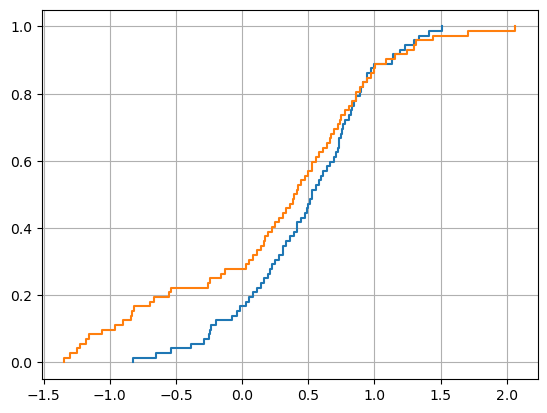

In [26]:
fortbliss_ecdf_model=ecdf(normalized_model)
fortbliss_ecdf_actual=ecdf(normalized_actual)
plot_ecdf(fortbliss_ecdf_model)
plot_ecdf(fortbliss_ecdf_actual)

In [27]:
# Compute Pearson correlation
corr, _ = pearsonr(fortbliss_energy_mw['pvlib model'], fortbliss_energy_mw['Actual Production'])

print(f"Pearson Correlation: {corr}")
# Compute Euclidean distance
dist = euclidean(fortbliss_energy_mw['pvlib model'], fortbliss_energy_mw['Actual Production'])

print(f"Euclidean Distance: {dist}")


Pearson Correlation: 0.7962844902542217
Euclidean Distance: 488.4165168041742


In [28]:
montana_energy_model_mw=np.array([])
montana_energy_model_mw=np.append(montana_energy_model_mw,[mont_annual_production_list_2019,mont_annual_production_list_2020,mont_annual_production_list_2021])
montana_energy_mw['pvlib model']=montana_energy_model_mw

In [29]:
corr, _ = pearsonr(montana_energy_mw['pvlib model'], montana_energy_mw['Actual Production'])
print(f"Pearson Correlation: {corr}")
dist = euclidean(montana_energy_mw['pvlib model'], montana_energy_mw['Actual Production'])
print(f"Euclidean Distance: {dist}")
dist = energy_distance(montana_energy_mw['pvlib model'], montana_energy_mw['Actual Production'])
print(f"Energy Distance: {dist}")

Pearson Correlation: 0.8879827569000758
Euclidean Distance: 1768.1404542326977
Energy Distance: 13.733841025897814


In [30]:
file_path_ercot=r'C:\Users\Zelda64\Documents\Programming\dust_solar_power\ERCOT'
ercot_dam_2019_path=os.path.join(file_path_ercot,"rpt.00013060.0000000000000000.DAMLZHBSPP_2019.xlsx")
ercot_rtm_2019_path=os.path.join(file_path_ercot,"rpt.00013061.0000000000000000.RTMLZHBSPP_2019.xlsx")

In [31]:
ercot_dam_2019=pd.read_excel(ercot_dam_2019_path, index_col=0)#, index_col=0,engine="python")
ercot_rtm_2019=pd.read_excel(ercot_rtm_2019_path, index_col=0)

In [32]:
ercot_dam_2019=ercot_dam_2019.drop(['Hour Ending', 'Repeated Hour Flag'], axis=1)
ercot_dam_2019

,Settlement Point,Settlement Point Price
Delivery Date,,
01/01/2019,HB_BUSAVG,20.49
01/01/2019,HB_HOUSTON,20.12
01/01/2019,HB_HUBAVG,20.54
01/01/2019,HB_NORTH,20.49
01/01/2019,HB_SOUTH,20.34
...,...,...
01/31/2019,LZ_LCRA,19.53
01/31/2019,LZ_NORTH,19.46
01/31/2019,LZ_RAYBN,20.29


In [33]:
for term in ercot_dam_2019['Settlement Point'].unique():
    print(ercot_dam_2019[ercot_dam_2019['Settlement Point']==term].shape)

(744, 2)
(744, 2)
(744, 2)
(744, 2)
(744, 2)
(744, 2)
(744, 2)
(744, 2)
(744, 2)
(744, 2)
(744, 2)
(744, 2)
(744, 2)
(744, 2)


In [34]:
ercot_rtm_2019=ercot_rtm_2019.drop(['Delivery Hour', 'Delivery Interval', 'Repeated Hour Flag', 'Settlement Point Type'], axis=1)
ercot_rtm_2019

,Settlement Point Name,Settlement Point Price
Delivery Date,,
01/01/2019,HB_BUSAVG,10.63
01/01/2019,HB_BUSAVG,14.24
01/01/2019,HB_BUSAVG,15.27
01/01/2019,HB_BUSAVG,14.98
01/01/2019,HB_HOUSTON,10.63
...,...,...
01/31/2019,LZ_WEST,20.46
01/31/2019,LZ_WEST,20.23
01/31/2019,LZ_WEST,20.23


In [35]:
zones=ercot_rtm_2019['Settlement Point Name'].unique()
n_zones=zones.shape

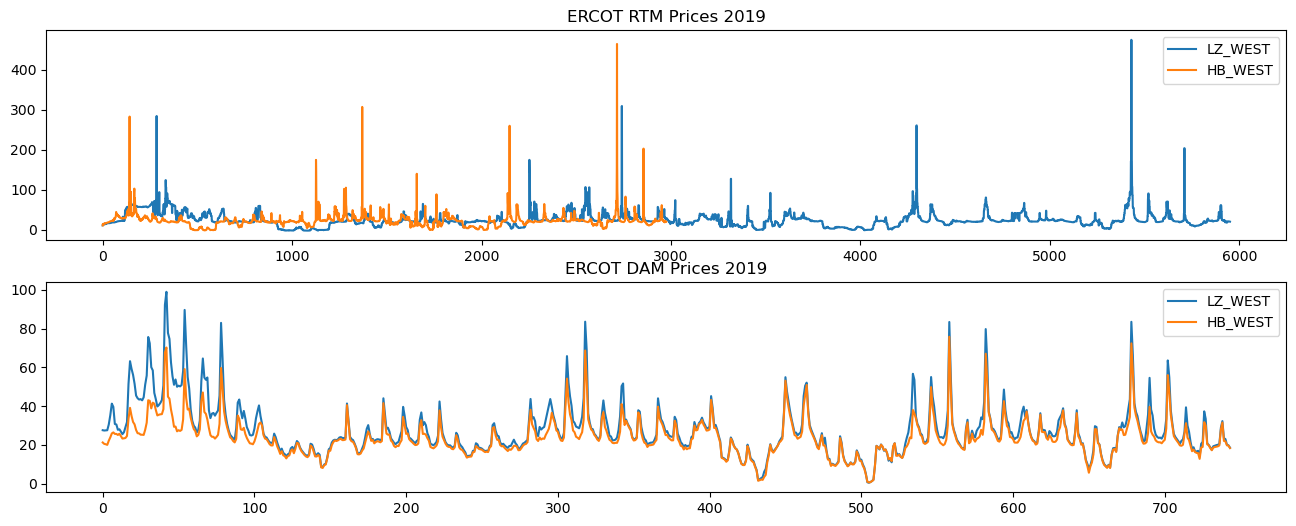

In [36]:
fig,ax = plt.subplots(2,1,figsize=(16, 6))
ercot_rtm_2019_zone_1=ercot_rtm_2019[ercot_rtm_2019['Settlement Point Name']=='LZ_WEST'].drop(['Settlement Point Name'],axis=1)
ercot_rtm_2019_zone_2=ercot_rtm_2019[ercot_rtm_2019['Settlement Point Name']=='HB_WEST'].drop(['Settlement Point Name'],axis=1)

ercot_dam_2019_zone_1=ercot_dam_2019[ercot_dam_2019['Settlement Point']=='LZ_WEST'].drop(['Settlement Point'],axis=1)
ercot_dam_2019_zone_2=ercot_dam_2019[ercot_dam_2019['Settlement Point']=='HB_WEST'].drop(['Settlement Point'],axis=1)
ax[0].set_title('ERCOT RTM Prices 2019')
ax[0].plot(ercot_rtm_2019_zone_1.values, label='LZ_WEST')
ax[0].plot(ercot_rtm_2019_zone_2.values, label='HB_WEST')
ax[0].legend(loc='upper right')
ax[1].set_title('ERCOT DAM Prices 2019')
ax[1].plot(ercot_dam_2019_zone_1.values, label='LZ_WEST')
ax[1].plot(ercot_dam_2019_zone_2.values, label='HB_WEST') 
ax[1].legend(loc='upper right')
